In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import backend as K

C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
train_data = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/train_sh.csv')
valid_data = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/valid_sh.csv')
test_data  = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/test_sh.csv')

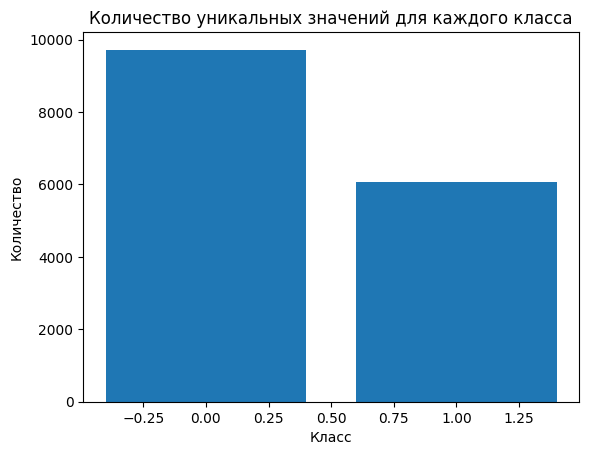

[0.81217856 1.30082372]
{0: 0.8121785640814647, 1: 1.300823723228995}


In [3]:
# Подсчет количества элементов класса_1 и класса_2 в столбце_1
class_counts = train_data['label'].value_counts()

# Построение гистограммы
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Количество уникальных значений для каждого класса')
plt.show()

from sklearn.utils.class_weight import compute_class_weight

# Получение уникальных меток классов
class_labels = train_data['label'].unique()

# Рассчитываем веса классов
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=train_data['label'])

print(class_weights)

# Создаем словарь с весами классов
class_weight_dict = dict(zip(class_labels, class_weights))

print(class_weight_dict)

In [4]:
tr_text = train_data['text']
tr_label = train_data['label']

val_text = valid_data['text']
val_label = valid_data['label']

ts_text = test_data['text']
ts_label = test_data['label']

In [5]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=512) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=512)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=512)
ts_y = to_categorical(ts_label)

In [6]:
max_words = 20000
max_len = 512
embedding_dim = 32

In [7]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(512, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(512, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(512, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(2, activation='sigmoid')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [8]:
# model = Sequential()     
# model.add(Embedding(10000, 32, input_length=50))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D(keepdims=True))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(6, activation='softmax'))

In [9]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2):
    epsilon = 1e-9
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_loss = -alpha * (1 - pt) ** gamma * tf.math.log(pt)
    return tf.reduce_mean(focal_loss)

def f1_score(y_true, y_pred):
    # Округляем предсказанные значения до бинарных (0 или 1)
    y_pred = K.round(y_pred)

    # Ищем True Positives, False Positives и False Negatives
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # Вычисляем precision и recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Вычисляем F1 score
    f1_score = 2 * precision * recall / (precision + recall + K.epsilon())
    
    # Усредняем F1 score по классам и возвращаем результат
    return K.mean(f1_score)

In [10]:
# Использование:
model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy', f1_score])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 512)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 32)      640000      ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 512, 32)      640000      ['embedding_1_input[0][0]']      
                                                                                              

In [11]:
batch_size = 256
epochs = 15
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/15
62/62 [==============================] - 15s 177ms/step - loss: 0.0496 - accuracy: 0.8278 - f1_score: 0.7650 - val_loss: 0.0373 - val_accuracy: 0.9715 - val_f1_score: 0.9687
Epoch 2/15
62/62 [==============================] - 11s 170ms/step - loss: 0.0012 - accuracy: 0.9940 - f1_score: 0.9935 - val_loss: 0.0322 - val_accuracy: 0.9913 - val_f1_score: 0.9907
Epoch 3/15
62/62 [==============================] - 11s 172ms/step - loss: 2.8973e-04 - accuracy: 0.9983 - f1_score: 0.9982 - val_loss: 0.0257 - val_accuracy: 0.9926 - val_f1_score: 0.9916
Epoch 4/15
62/62 [==============================] - 11s 174ms/step - loss: 1.1960e-04 - accuracy: 0.9992 - f1_score: 0.9992 - val_loss: 0.0194 - val_accuracy: 0.9928 - val_f1_score: 0.9920
Epoch 5/15
62/62 [==============================] - 11s 177ms/step - loss: 8.6203e-05 - accuracy: 0.9995 - f1_score: 0.9995 - val_loss: 0.0135 - val_accuracy: 0.9922 - val_f1_score: 0.9915
Epoch 6/15
62/62 [==============================] - 11s 173ms/s

In [12]:
(loss, accuracy, f1) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, F1: {round(f1, 2)}')

494/494 [==============================] - 3s 6ms/step - loss: 4.1745e-05 - accuracy: 0.9997 - f1_score: 0.9997
Loss: 0.0, Accuracy: 1.0, F1: 1.0


In [13]:
(loss, accuracy, f1) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, F1: {round(f1, 2)}')

165/165 [==============================] - 1s 6ms/step - loss: 0.0019 - accuracy: 0.9930 - f1_score: 0.9925
Loss: 0.0, Accuracy: 0.99, F1: 0.99


In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])

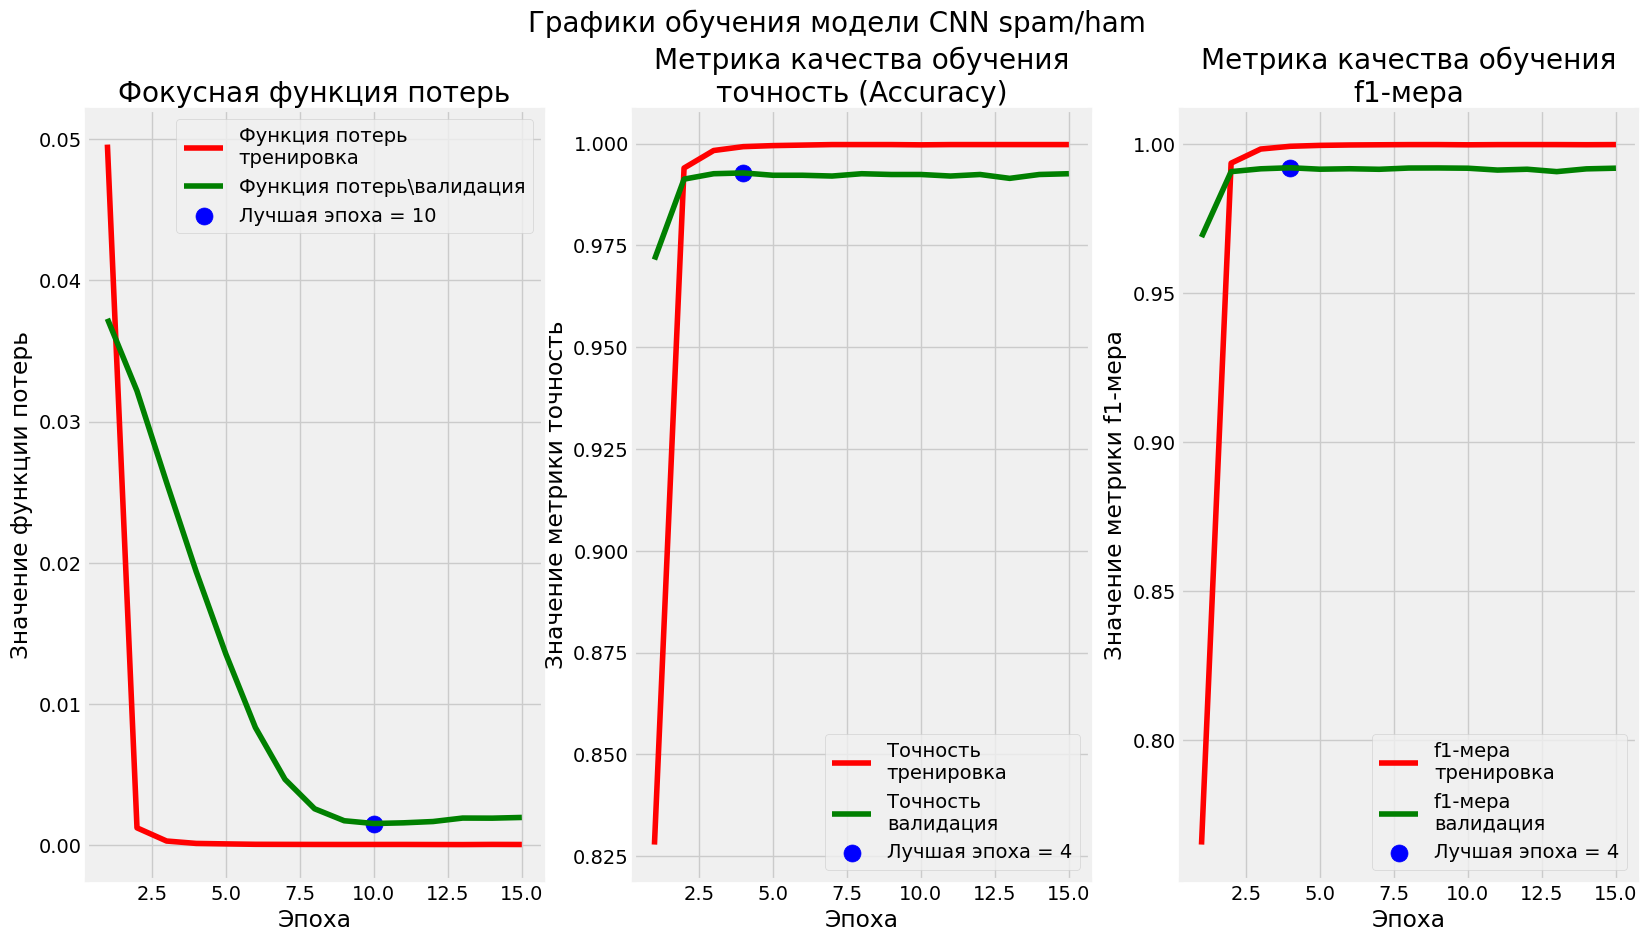

In [15]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_f1 = history.history['f1_score']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_f1 = history.history['val_f1_score']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_f1 = np.argmax(val_f1)
f1_highest = val_f1[index_f1]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Лучшая эпоха = {str(index_loss + 1)}'
acc_label = f'Лучшая эпоха = {str(index_acc + 1)}'
f1_label = f'Лучшая эпоха = {str(index_f1 + 1)}'


fig = plt.figure(figsize=(20, 10))
plt.style.use('fivethirtyeight')


plt.subplot(1, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label='Функция потерь\nтренировка')
plt.plot(Epochs, val_loss, 'g', label='Функция потерь\валидация')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Фокусная функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label='Точность\nтренировка')
plt.plot(Epochs, val_acc, 'g', label='Точность\nвалидация')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Метрика качества обучения\nточность (Accuracy)')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(Epochs, tr_f1, 'r', label='f1-мера\nтренировка')
plt.plot(Epochs, val_f1, 'g', label='f1-мера\nвалидация')
plt.scatter(index_f1 + 1, f1_highest, s=150, c='blue', label=f1_label)
plt.title('Метрика качества обучения\nf1-мера')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики f1-мера')
plt.legend()
plt.grid(True)

plt.suptitle('Графики обучения модели CNN spam/ham', fontsize=20)
plt.show()
fig.savefig("plot_train_inf", dpi=1000)

In [16]:
y_true=[]
for i in range(len(ts_y)):
    
    x = np.argmax(ts_y[i]) 
    y_true.append(x)

In [17]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

165/165 [==============================] - 1s 4ms/step


array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

<Axes: >

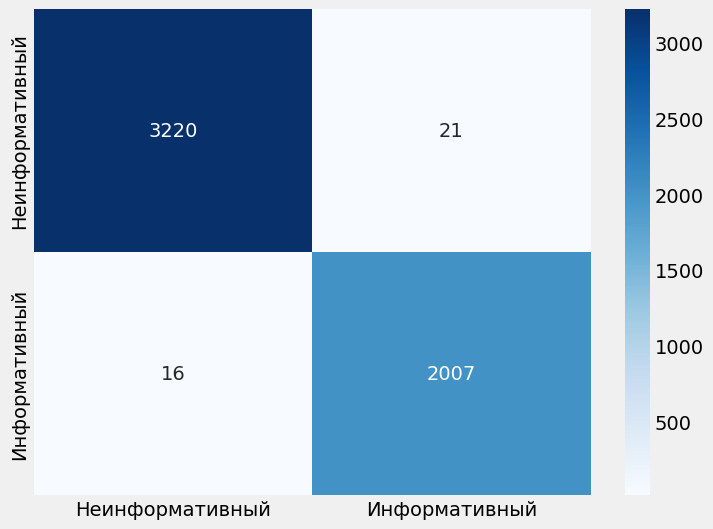

In [18]:
plt.figure(figsize=(8,6))
emotions = {0: 'Неинформативный', 1: 'Информативный'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
# fig.savefig("conf_matrix_inf", dpi=1000)

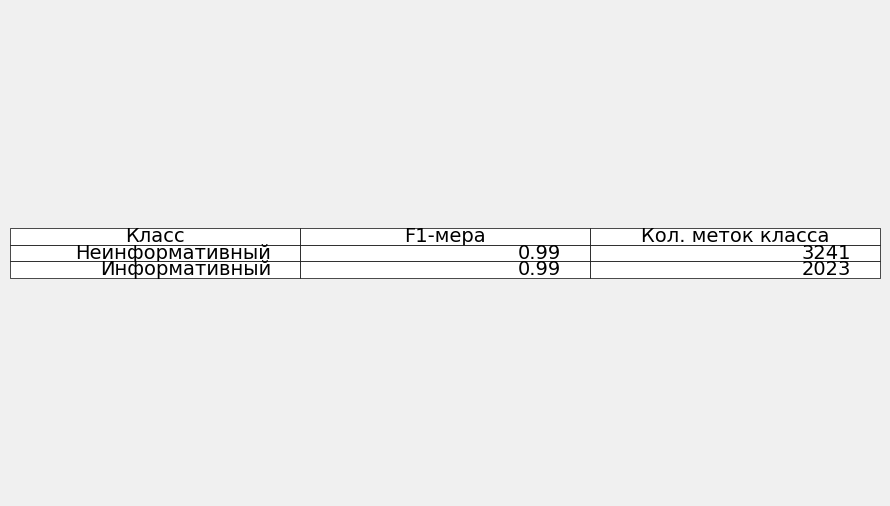

In [19]:
clr = classification_report(y_true, y_pred)

report_data = []
report_lines = clr.split('\n')
for line in report_lines[2:-5]:  # Игнорируем первые две строки заголовка и последние пять строк с общими показателями
    row_data = line.split()
    # Замена значений классов 0 и 1 на "Неинформативный" и "Информативный"
    if row_data[0] == '0':
        row_data[0] = 'Неинформативный'
    elif row_data[0] == '1':
        row_data[0] = 'Информативный'
    # Исключаем столбцы Precision и Recall из таблицы
    row_data = [row_data[0], row_data[3], row_data[4]]  # Пропускаем столбцы Precision и Recall
    report_data.append(row_data)

# Создание таблицы matplotlib
fig, ax = plt.subplots(figsize=(10, 6))  # Установка размеров рисунка
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_data, loc='center', colLabels=['Класс', 'F1-мера', 'Кол. меток класса'])

# Сохранение рисунка
# plt.savefig('classification_report_inf.png', dpi=1000)  # Сохранить в виде изображения
plt.show()

In [20]:
import pickle
with open('tokenizer_inf.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('nlp_inf.h5')

In [21]:
def load_model_with_focal_loss(model_path):
    custom_objects = {'focal_loss': focal_loss, 'f1_score': f1_score}  # Добавляем пользовательскую функцию потерь в custom_objects
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    return model

In [22]:
import numpy as np

# Функция predict остается неизменной, но при вызове используется numpy.argmax для определения предсказанного класса

def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model_with_focal_loss(model_path)
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences(text)
    x_new = pad_sequences(sequences, maxlen=512)
    predictions = model.predict([x_new, x_new])
    
    # Использование numpy.argmax для определения предсказанного класса
    predicted_labels = np.argmax(predictions, axis=1)
    
    return predicted_labels

# Загрузка данных test_data и их предсказание
texts = list(test_data['text'])
labels = list(test_data['label'])

predicted_labels = predict(texts, 'nlp_inf.h5', 'tokenizer_inf.pkl')

# Вызов функции precision_recall_fscore_support с обновленными labels и predicted_labels
from sklearn.metrics import precision_recall_fscore_support

_, _, f1score, _ = precision_recall_fscore_support(labels, predicted_labels, average='micro')

print(f'f1score: {f1score}')

df = pd.DataFrame()
df = test_data
df['predict'] = predicted_labels
df

165/165 [==============================] - 1s 4ms/step
f1score: 0.9929711246200608


,text,label,predict
0,осеньоднако здрасти на улице 12 комфортно,0,0
1,суздаль топ валенки лучшая обувь зима приколь...,0,0
2,вздутый от гордости что я могу быть отличным а...,1,1
3,10 фотография ваше лето,0,0
4,зима в израиле раз,0,0
...,...,...,...
5259,сталин смеется над устаревшим смартфоном черчи...,0,0
5260,для всего флэшбека подходят\n\nмай аффинаж\nд...,0,0
5261,великий,1,1
5262,февраль 2015 войдёт в историю россии вот этими...,0,0


In [23]:
def predict1(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model_with_focal_loss(model_path)
    
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=512)
    predictions = model.predict([x_new, x_new])
    
    emotions = {0: 'Неинформативный', 1: 'Информативный'}
    
    label = list(emotions.values())
    probs = list(predictions[0])
    labels = label
    plt.subplot(1, 1, 1)
    bars = plt.barh(labels, probs)
    plt.xlabel('Вероятность принадлежнности классу', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 0s 91ms/step


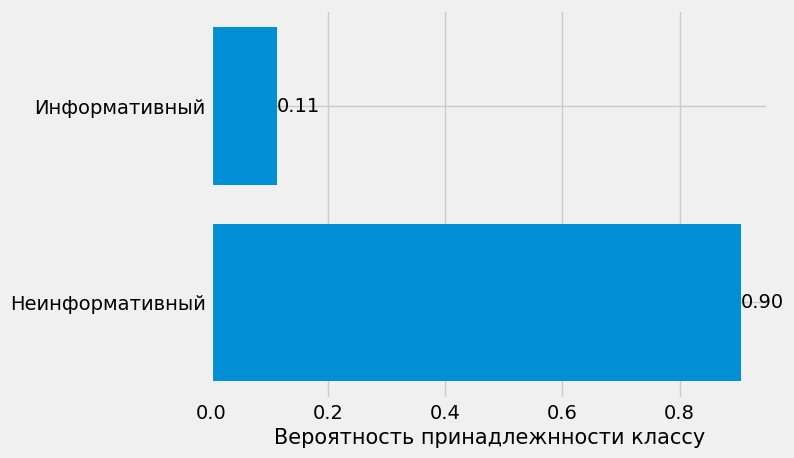

In [24]:
txt = 'Кто такой Ленин?'
predict1(txt, 'nlp_inf.h5', 'tokenizer_inf.pkl')

In [25]:
import numpy as np

test_data = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/test_sh_tr.csv')

# Функция predict остается неизменной, но при вызове используется numpy.argmax для определения предсказанного класса

def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model_with_focal_loss(model_path)
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences(text)
    x_new = pad_sequences(sequences, maxlen=512)
    predictions = model.predict([x_new, x_new])
    
    # Использование numpy.argmax для определения предсказанного класса
    predicted_labels = np.argmax(predictions, axis=1)
    
    return predicted_labels

# Загрузка данных test_data и их предсказание
texts = list(test_data['text'])
labels = list(test_data['label'])

predicted_labels = predict(texts, 'nlp_inf.h5', 'tokenizer_inf.pkl')

y_true=[]
for i in range(len(labels)):

    y_true.append(labels[i])
    
y_pred = predicted_labels

# Вызов функции precision_recall_fscore_support с обновленными labels и predicted_labels
from sklearn.metrics import precision_recall_fscore_support

_, _, f1score, _ = precision_recall_fscore_support(labels, predicted_labels, average='micro')

print(f'f1score: {f1score}')

df = pd.DataFrame()
df = test_data
df['predict'] = predicted_labels
df

4/4 [==============================] - 0s 8ms/step
f1score: 0.7864077669902912


,text,label,predict
0,основы программирования интерактивный подход к...,1,1
1,основы программирования подробное объяснение л...,1,1
2,основы программирования введение в программиро...,1,1
3,основы программирования понятное изложение осн...,1,1
4,основы программирования кларность и структура ...,1,1
...,...,...,...
98,основы программирования преподователь раз тако...,1,0
99,новейшие тенденции в it очень понравилось изуч...,1,0
100,новейшие тенденции в it очень подробный разбор...,1,1
101,java api браузеров понравилась тема да преподо...,1,0


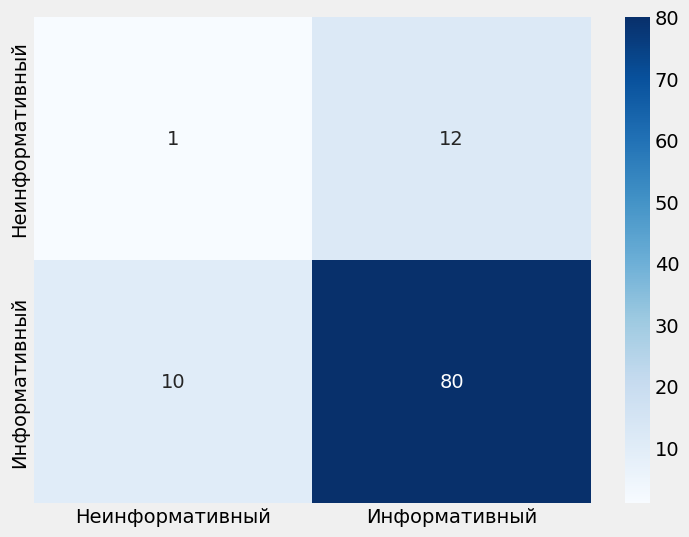

In [26]:
fig = plt.figure(figsize=(8,6))
emotions = {0: 'Неинформативный', 1: 'Информативный'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
fig.savefig("conf_matrix_inf.png", dpi=1000)

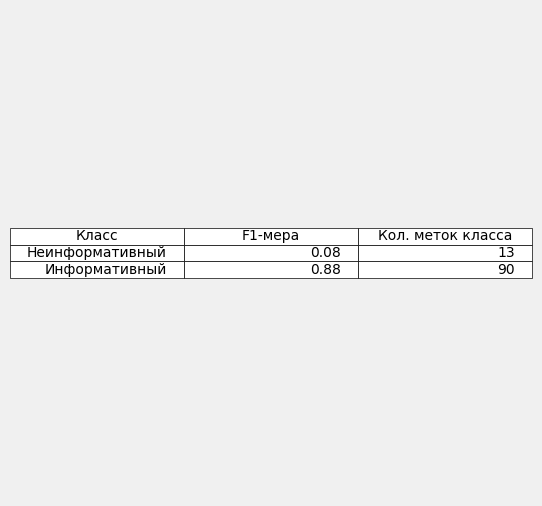

In [27]:
clr = classification_report(y_true, y_pred)

# Преобразование текста отчета о классификации в массив NumPy
report_data = []
report_lines = clr.split('\n')
for line in report_lines[2:-5]:  # Игнорируем первые две строки заголовка и последние пять строк с общими показателями
    row_data = line.split()
    # Замена значений классов 0 и 1 на "negative" и "positive"
    if row_data[0] == '0':
        row_data[0] = 'Неинформативный'
    elif row_data[0] == '1':
        row_data[0] = 'Информативный'
    # Исключаем столбцы Precision и Recall из таблицы
    row_data = [row_data[0], row_data[3], row_data[4]]  # Пропускаем столбцы Precision и Recall
    report_data.append(row_data)

# Создание таблицы matplotlib
fig, ax = plt.subplots(figsize=(6, 6))  # Установка размеров рисунка
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_data, loc='center', colLabels=['Класс', 'F1-мера', 'Кол. меток класса'])

# Сохранение рисунка
plt.savefig('classification_report_inf.png', dpi=1000)  # Сохранить в виде изображения
plt.show()